In [1]:
import sys
sys.path.append('/home/yungdankblast/DelayedOptimization')
from FuncOptHandler import Handler
import numpy as np
from Optimizer_Scripts.DelayTypeGenerators import Undelayed, Uniform, Stochastic, Partial
from Optimizer_Scripts.LossFunc import LossFunc
from Optimizer_Scripts.Data import Data
from matplotlib import pyplot as plt

In [2]:
def get_state_arr(data):    # 1D function only
    state_arr = np.empty([len(data.state_vals), data.maxiter+1])
    for j, state_vals in enumerate(data.state_vals):
        state_vals = state_vals.flatten()
        state_arr[j][:len(state_vals)] = state_vals
        state_arr[j][len(state_vals):] = state_vals[-1]
    return state_arr  

def plot_time_loss(undel_data, del_data):
    plt.plot(np.mean(undel_data.get_loss_array(), axis=0), label="Undelayed", alpha=0.5)
    plt.plot(np.mean(del_data.get_loss_array(), axis=0), label="Delayed", alpha=0.5)
    plt.title("Mean Loss Over Time")
    plt.legend()
    plt.show()

def plot_time_state(undel_data, del_data):
    plt.plot(get_state_arr(undel_data).T, label="Undelayed", color="C0", alpha=0.01)
    plt.plot(get_state_arr(del_data).T, label="Delayed", color="C1", alpha=0.01)
    plt.title("State Values Over Time")
    plt.show()

def plot_final_states(data, xlim=None):
    loss = data.get_loss_function()
    xlim = loss.domain if xlim is None else xlim
    x = np.linspace(*xlim, 100)
    y = [loss.loss(np.array([val])) for val in x]
    
    if data.delay_params['delay_type'].lower() == "undelayed":
        delay_str = "Undelayed"
    else:
        delay_str = "Delayed"

    plt.plot(x, y, label="Loss Function")
    plt.scatter(data.get_finals(data.state_vals), data.get_finals(data.loss_vals), label=f"{delay_str} Final States", color="red", alpha=0.01, zorder=10)
    plt.title(f"{delay_str} Final State Values")
    plt.show()

In [3]:
stable_handler = Handler("stable", 1)

## Check that the new loss function is working as intended

In [4]:
loss = LossFunc("stable", 1)

In [5]:
loss.__dict__

{'loss_name': 'stable',
 'n': 1,
 'loss': <function Optimizer_Scripts.functions.stable_gen.<locals>.stable(x, *args)>,
 'grad': <function Optimizer_Scripts.functions.stable_deriv_gen.<locals>.stable_grad(x, *args)>,
 'domain': [-3.0, 3.0],
 'minimizer': array([0.])}

## Try optimizing (250 points in (-5,5))

In [6]:
stable_handler.random_points(250)

In [7]:
stable_handler.x_inits.shape    # Generated correctly

(250, 1)

In [8]:
undel_const_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "const",
    learning_rate = .6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 29.81it/s]


In [11]:
del_const_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "const",
    learning_rate = .5,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 26.76it/s]


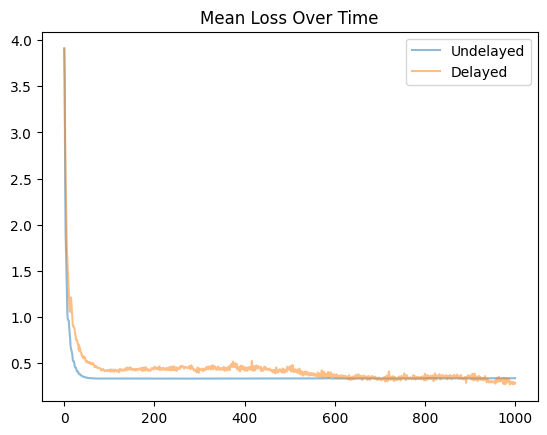

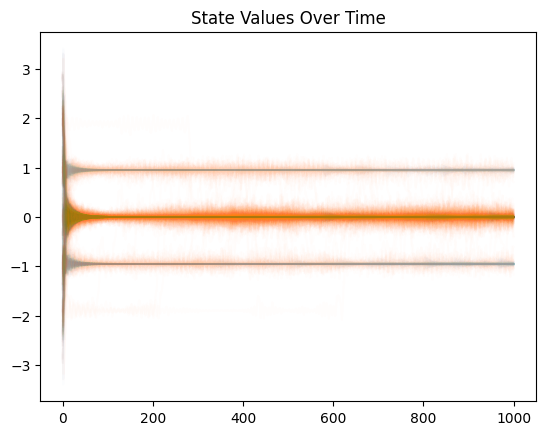

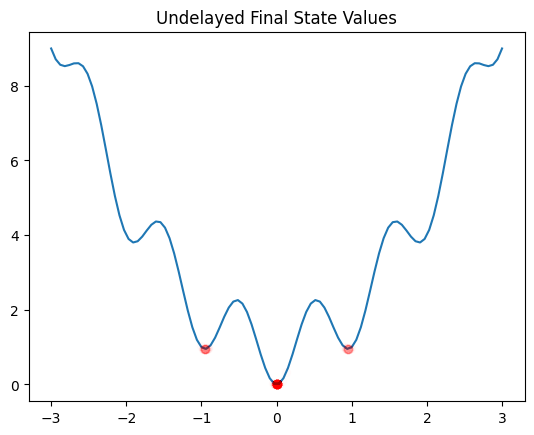

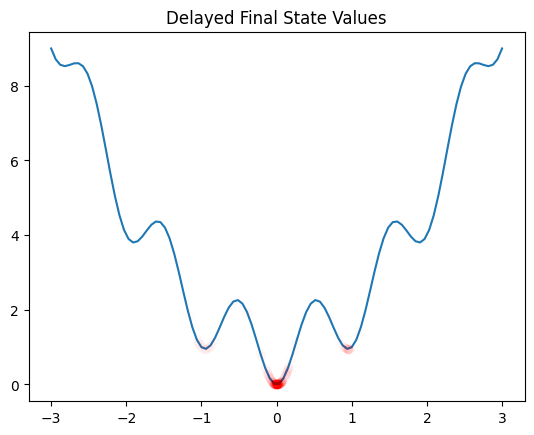

In [12]:
undel_data = undel_const_data
del_data = del_const_data
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

## Try with Decaying Learning Rate

##### Linear

In [13]:
undel_linear_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "linear",
    max_lr = 3,
    min_lr = 0,
    num_steps = 1000,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 29.50it/s]


In [14]:
del_linear_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "linear",
    max_lr = 3,
    min_lr = 0,
    num_steps = 1000,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 26.08it/s]


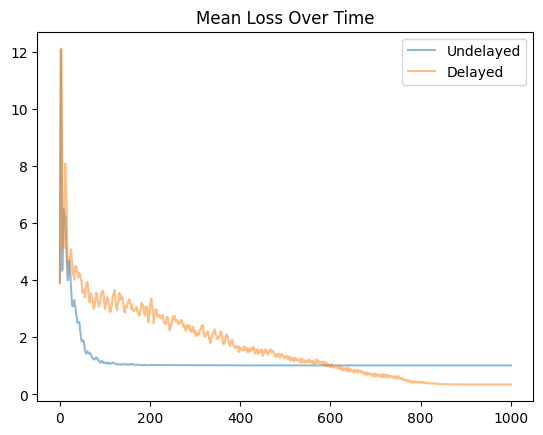

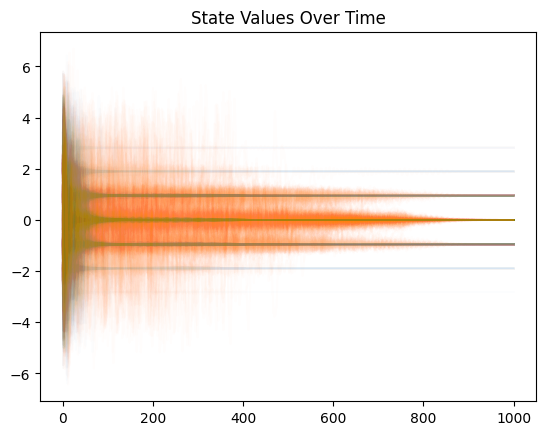

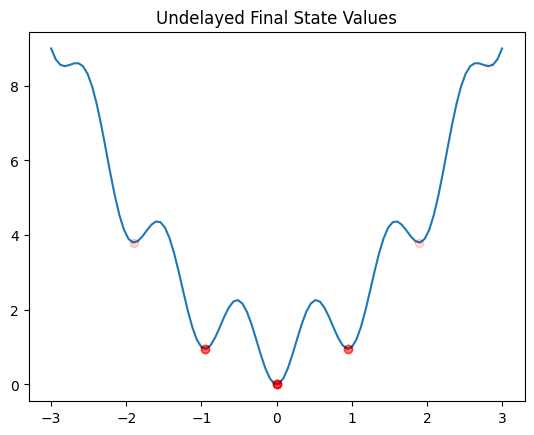

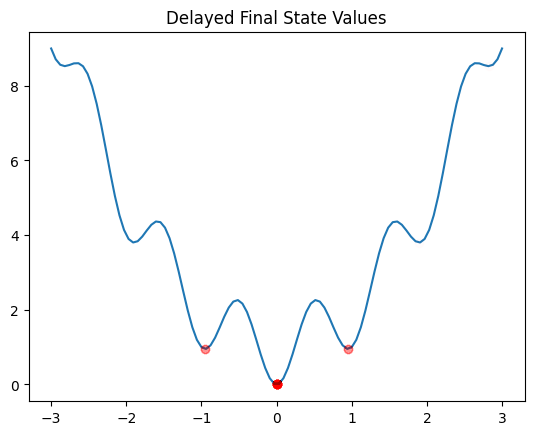

In [15]:
undel_data = undel_linear_data
del_data = del_linear_data
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

##### Inverse-Time

In [16]:
undel_inv_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 28.81it/s]


In [17]:
del_inv_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 25.21it/s]


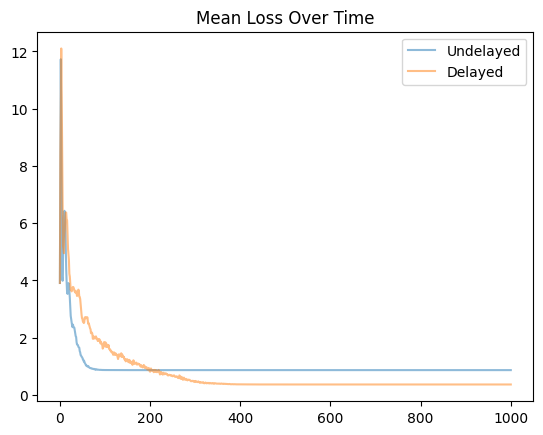

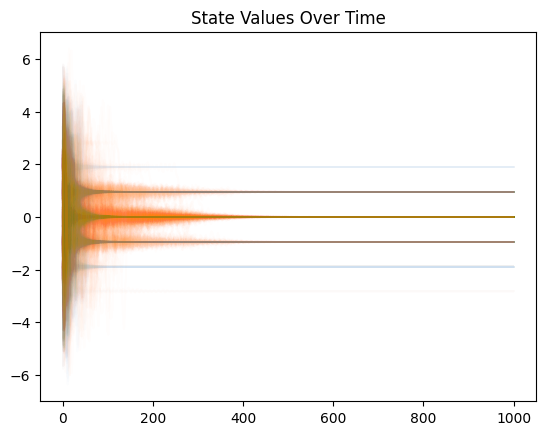

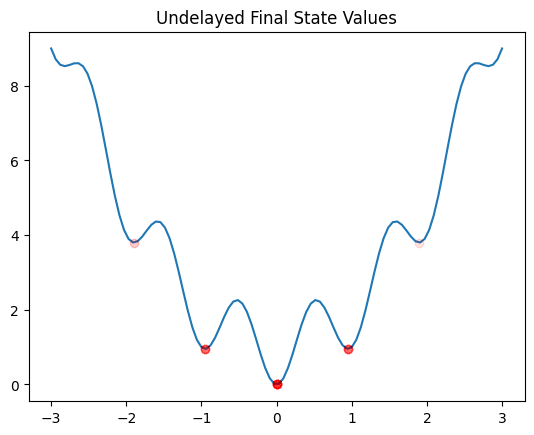

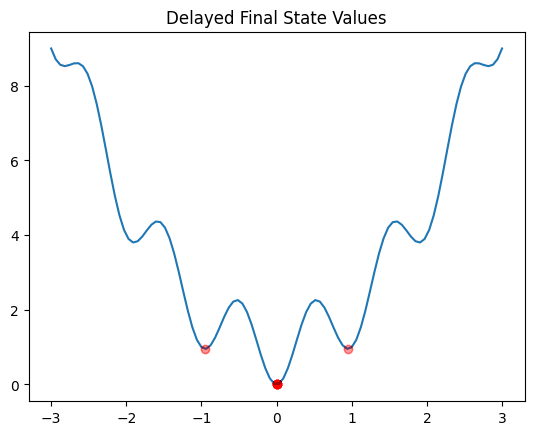

In [18]:
undel_data = undel_inv_data
del_data = del_inv_data
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

## Local Nature

In [19]:
x_inits = np.random.uniform(-.1, .1, 250).reshape(-1,1)
stable_handler.load_points(x_inits)

##### Constant Learning Rate

In [20]:
undel_loc_const_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "const",
    learning_rate = 1e-3,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 28.50it/s]


In [21]:
del_loc_const_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "const",
    learning_rate = 1e-3,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 27.09it/s]


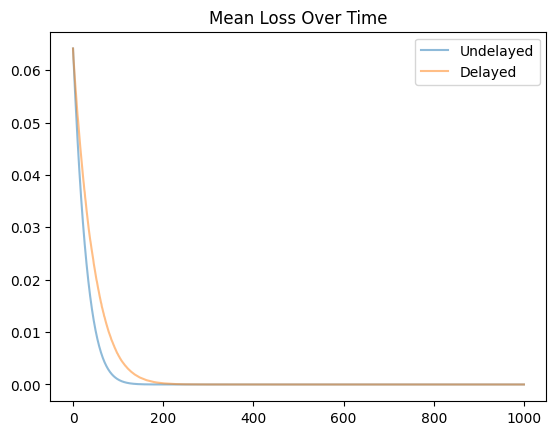

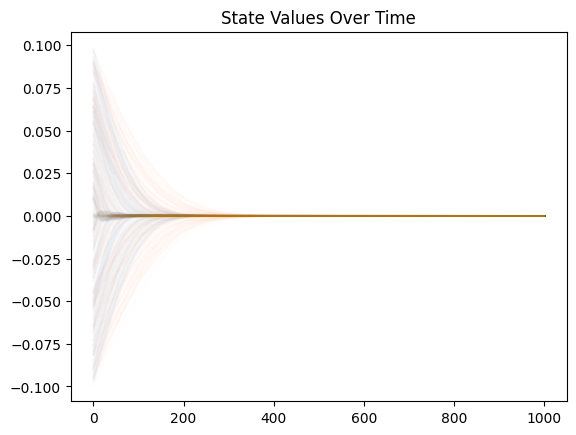

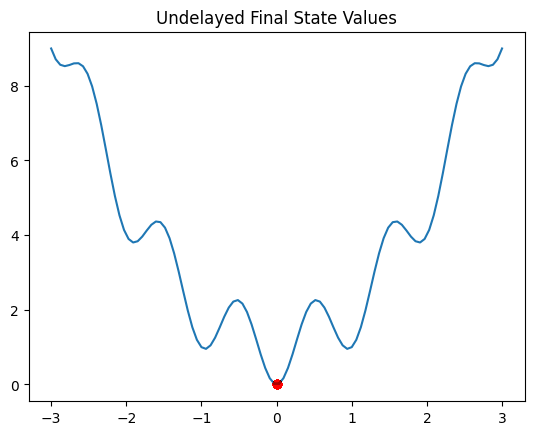

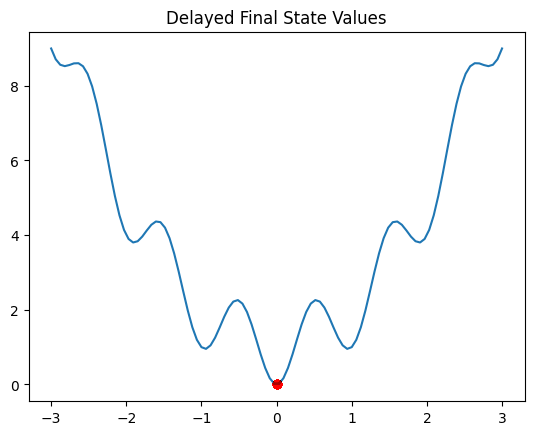

In [22]:
undel_data = undel_loc_const_data
del_data = del_loc_const_data
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

##### Linear Decaying Learning Rate

In [23]:
undel_loc_linear_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "linear",
    max_lr = 3,
    min_lr = 0,
    num_steps = 1000,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:08<00:00, 28.27it/s]


In [24]:
del_loc_linear_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "linear",
    max_lr = 3,
    min_lr = 0,
    num_steps = 1000,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 25.73it/s]


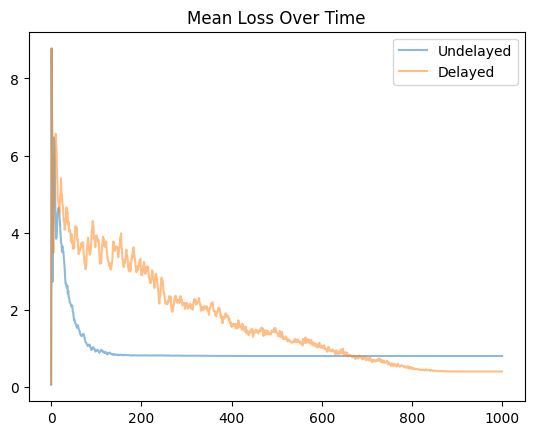

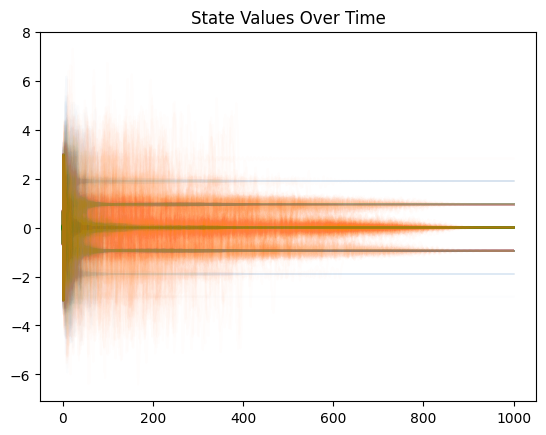

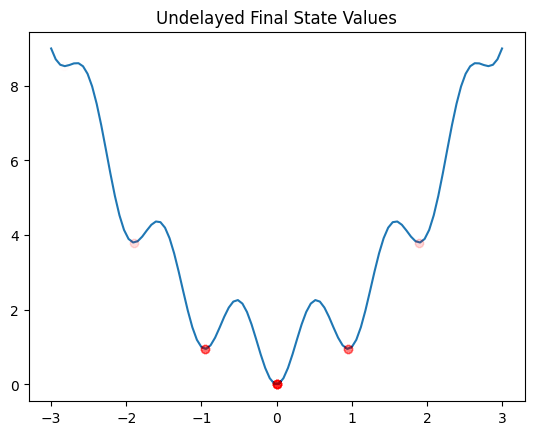

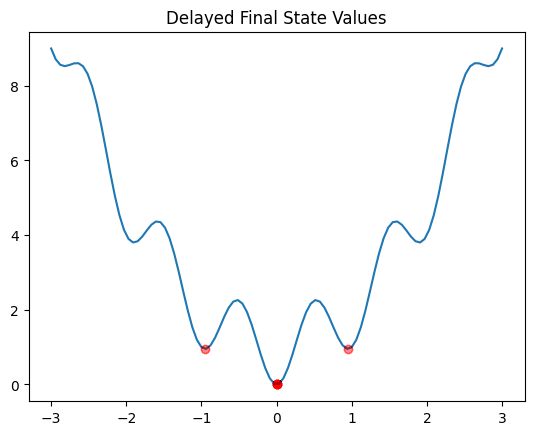

In [25]:
undel_data = undel_loc_linear_data
del_data = del_loc_linear_data
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)

##### Inverse-Time Decaying Learning Rate

In [26]:
undel_loc_inv_data = stable_handler.optimize(
    delay_type = Undelayed(), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (undelayed): 100%|██████████| 250/250 [00:09<00:00, 27.76it/s]


In [27]:
del_loc_inv_data = stable_handler.optimize(
    delay_type = Stochastic(max_L=1, num_delays=1000), 
    lr_type = "inv",
    max_lr = 3,
    gamma = .001,
    p = 6,
    maxiter = 1000,
    tol = 1e-5,
    break_opt = False,
    )

stable 1d (stochastic): 100%|██████████| 250/250 [00:09<00:00, 26.93it/s]


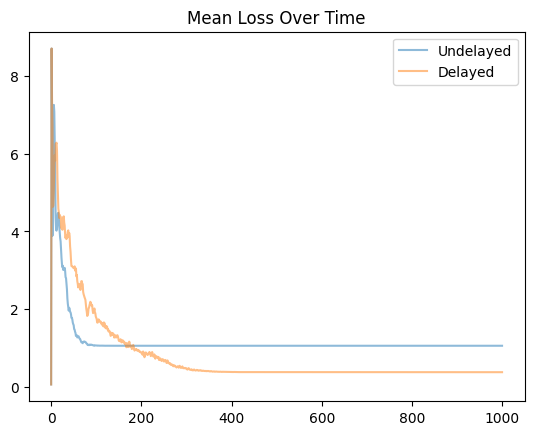

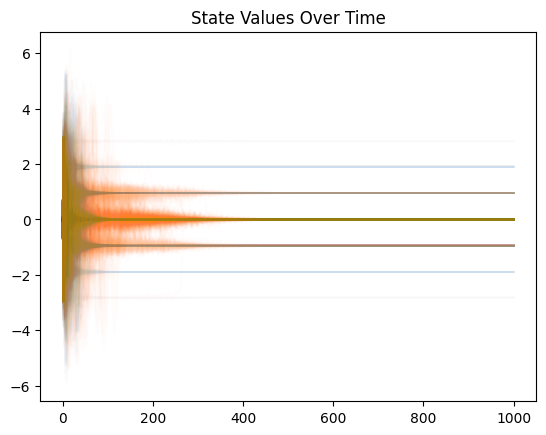

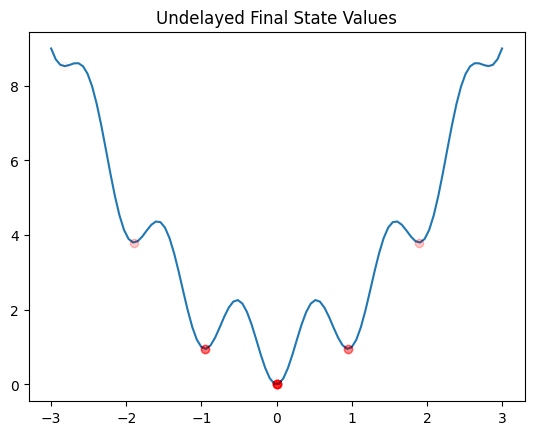

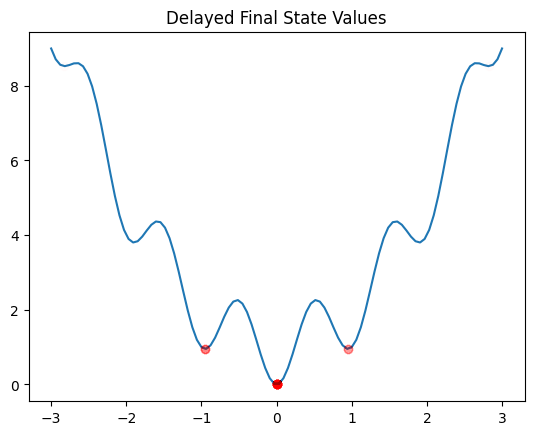

In [28]:
undel_data = undel_loc_inv_data
del_data = del_loc_inv_data
xlim = [-3, 3]

plot_time_loss(undel_data, del_data)
plot_time_state(undel_data, del_data)
plot_final_states(undel_data, xlim=xlim)
plot_final_states(del_data, xlim=xlim)